# Readme
pytorch 主要课程安排：
1. pytorch 的基本概念
2. pytorch 的基本操作
3. pytorch 的模型构建
4. pytorch 的模型训练
5. pytoch 实战 -- MNIST

In [59]:
!pip install torch 

x (1797, 64)


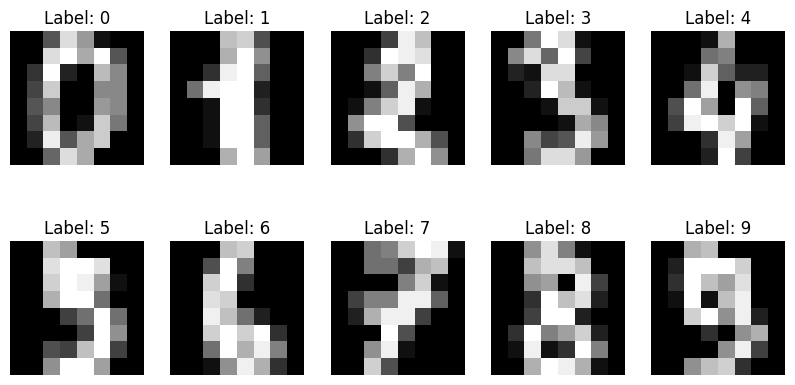

In [48]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier  # 多层感知机分类器
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 加载手写数字数据集（1797张8x8像素的数字图片）
digits = load_digits()
X = digits.data  # 特征：64维向量（每张图片8x8像素）
labels = digits.target  # 标签：0-9的数字

print("x" , X.shape)
# 可视化前10张图片
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.show()

In [50]:

import torch
# 数据预处理：重塑为图像格式并归一化
print(X.shape)
print(X.max())  # 打印X的最大值

X = X.reshape(-1, 1, 8, 8)  # 重塑为 (样本数, 通道数, 高度, 宽度)
X = X / X.max() # 将像素值归一化到 [0,1] 范围

feature_train, feature_validate, target_train, target_validate = train_test_split(X, labels, test_size = 0.1, random_state = 0)

# 转换为PyTorch张量
X_train = torch.FloatTensor(feature_train)
y_train = torch.LongTensor(target_train)
X_test = torch.FloatTensor(feature_validate)
y_test = torch.LongTensor(target_validate)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1797, 1, 8, 8)
1.0
torch.Size([1617, 1, 8, 8]) torch.Size([1617]) torch.Size([180, 1, 8, 8]) torch.Size([180])


In [51]:
from torch.utils.data import DataLoader, TensorDataset

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)
print(train_dataset)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
# 定义CNN模型（适应8x8图像）
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)  # 输入通道1，输出通道10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)  # 输入通道10，输出通道20
        self.conv2_drop = nn.Dropout2d()  # 卷积层的Dropout
        self.fc1 = nn.Linear(20 * 1 * 1, 50)  # 全连接层
        self.fc2 = nn.Linear(50, 10)  # 输出层

    def forward(self, x):
        x = self.conv1(x)  # 卷积操作 (8-3+1=6) -> 6x6
        x = nn.functional.max_pool2d(x, 2)  # 最大池化 -> 3x3
        x = nn.functional.relu(x)  # ReLU激活函数
        
        x = self.conv2(x)  # 第二次卷积 (3-3+1=1) -> 1x1
        x = self.conv2_drop(x)  # Dropout防止过拟合
        x = nn.functional.max_pool2d(x, 1)  # 池化 (保持1x1)
        x = nn.functional.relu(x)  # ReLU激活函数
        
        x = x.view(-1, 20 * 1 * 1)  # 展平为一维向量
        x = self.fc1(x)  # 全连接层
        x = nn.functional.relu(x)  # ReLU激活函数
        x = nn.functional.dropout(x, training=self.training)  # Dropout
        x = self.fc2(x)  # 输出层
        return nn.functional.log_softmax(x, dim=1)  # 对数Softmax激活函数


In [53]:
# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = CNN().to(device)
criterion = nn.NLLLoss()  # 负对数似然损失
optimizer = optim.Adam(model.parameters(), lr=0.001)


使用设备: cpu


In [58]:
import time
# 训练模型
def train(epochs):
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        end_time = time.time()
        print(f'Epoch {epoch+1}/{epochs}, 损失: {running_loss/len(train_loader):.4f}, 耗时: {end_time-start_time:.2f}秒')
# 训练和评估
print("OK开始训练CNN模型...")
train(epochs=10)  # 由于数据集较小，增加训练轮次

OK开始训练CNN模型...
Epoch 1/10, 损失: 0.5919, 耗时: 0.08秒
Epoch 2/10, 损失: 0.6029, 耗时: 0.05秒
Epoch 3/10, 损失: 0.5853, 耗时: 0.04秒
Epoch 4/10, 损失: 0.5917, 耗时: 0.05秒
Epoch 5/10, 损失: 0.6030, 耗时: 0.04秒
Epoch 6/10, 损失: 0.6434, 耗时: 0.04秒
Epoch 7/10, 损失: 0.5912, 耗时: 0.07秒
Epoch 8/10, 损失: 0.5798, 耗时: 0.04秒
Epoch 9/10, 损失: 0.6159, 耗时: 0.04秒
Epoch 10/10, 损失: 0.5708, 耗时: 0.04秒


In [57]:
# 评估模型
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # 获取最大概率的索引
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'测试集: 平均损失: {test_loss:.4f}, 准确率: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
print("\n开始评估模型...")
test()


开始评估模型...
测试集: 平均损失: 0.2249, 准确率: 169/180 (93.89%)
